In [1]:
import os
os.getcwd()

from src.data_loader import load_and_clean_generation
from src.data_loader import load_and_clean_sensor
from src.data_loader import plot_dayly_timeseries
from src.shared_imports import *

DC/AC 在物理上的意义

DC_POWER：太阳能电池板产生的原始直流功率 → 受辐照度、温度、组件状态影响

AC_POWER：逆变器将 DC 转成 AC 后的并网功率 → 受逆变器容量、效率、限制影响
通过分析 DC→AC 的转换：

判断逆变器是否正常工作

检查是否有逆变器限载（AC clipping）

评估整体系统效率（DC/AC ratio、Conversion efficiency）

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
pwd

'e:\\solar-power-forecast-project'

### ①数据读取+基础统计<br>df.head(), describe(), NA 分布<br>时间范围<br>逆变器数量

In [4]:
data_path_gen = Path("data/raw/Plant_1_Generation_Data.csv")
data_path_sen = Path("data/raw/Plant_1_Weather_Sensor_Data.csv")
gen_1 = pd.read_csv(data_path_gen)

In [5]:
gen_1.drop('PLANT_ID', axis=1, inplace=True)

In [6]:
gen_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   SOURCE_KEY   68778 non-null  object 
 2   DC_POWER     68778 non-null  float64
 3   AC_POWER     68778 non-null  float64
 4   DAILY_YIELD  68778 non-null  float64
 5   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), object(2)
memory usage: 3.1+ MB


In [7]:
gen_1.describe()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,3147.426211,307.802752,3295.968737,6.978712e+06
std,4036.457169,394.396439,3145.178309,4.162720e+05
min,0.000000,0.000000,0.000000,6.183645e+06
25%,0.000000,0.000000,0.000000,6.512003e+06
50%,429.000000,41.493750,2658.714286,7.146685e+06
75%,6366.964286,623.618750,6274.000000,7.268706e+06
max,14471.125000,1410.950000,9163.000000,7.846821e+06


In [8]:
gen_1['DATE_TIME'] = pd.to_datetime(gen_1['DATE_TIME'])
gen_1 = gen_1.set_index("DATE_TIME")

C:\Users\pearl\AppData\Local\Temp\ipykernel_6400\1424997918.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gen_1['DATE_TIME'] = pd.to_datetime(gen_1['DATE_TIME'])


时间范围

In [9]:
gen_1.index

DatetimeIndex(['2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               ...
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=68778, freq=None)

In [10]:
gen_1.head(10)
gen_1["INVERTER_EFFICIENCY"] = gen_1["AC_POWER"]/gen_1["DC_POWER"].replace(0, np.nan)

In [11]:
gen_1_ac_dc = gen_1[["SOURCE_KEY","DC_POWER","AC_POWER","INVERTER_EFFICIENCY"]]
gen_1_pivot = gen_1_ac_dc.pivot(columns="SOURCE_KEY",values="INVERTER_EFFICIENCY")

In [12]:
gen_1_ac_dc.value_counts("DATE_TIME").sort_index

<bound method Series.sort_index of DATE_TIME
2020-06-17 23:45:00    22
2020-06-17 23:30:00    22
2020-06-17 23:15:00    22
2020-06-17 19:00:00    22
2020-06-17 18:45:00    22
                       ..
2020-05-27 18:45:00    10
2020-05-22 20:15:00    10
2020-05-26 19:00:00    10
2020-06-03 14:00:00     4
2020-05-25 05:30:00     4
Name: count, Length: 3158, dtype: int64>

逆变器数量及各自数据

In [13]:
gen_1_ac_dc.value_counts("SOURCE_KEY")

SOURCE_KEY
bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
VHMLBKoKgIrUVDU    3133
7JYdWkrLSPkdwr4    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
wCURE6d3bPkepu2    3126
z9Y9gH1T5YWrNuG    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
rGa61gmuvPhdLxV    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
adLQvlD726eNBSB    3119
1IF53ai7Xc0U56Y    3119
zBIq5rxdHJRwDNY    3119
3PZuoBAID5Wc2HD    3118
WRmjgnKYAwPKWDb    3118
YxYtjZvoooNbGkE    3104
Name: count, dtype: int64

### ② 时间趋势图

DC_POWER/AC_POWER vs TIME

Text(0.5, 1.0, 'DC/AC Distribution')

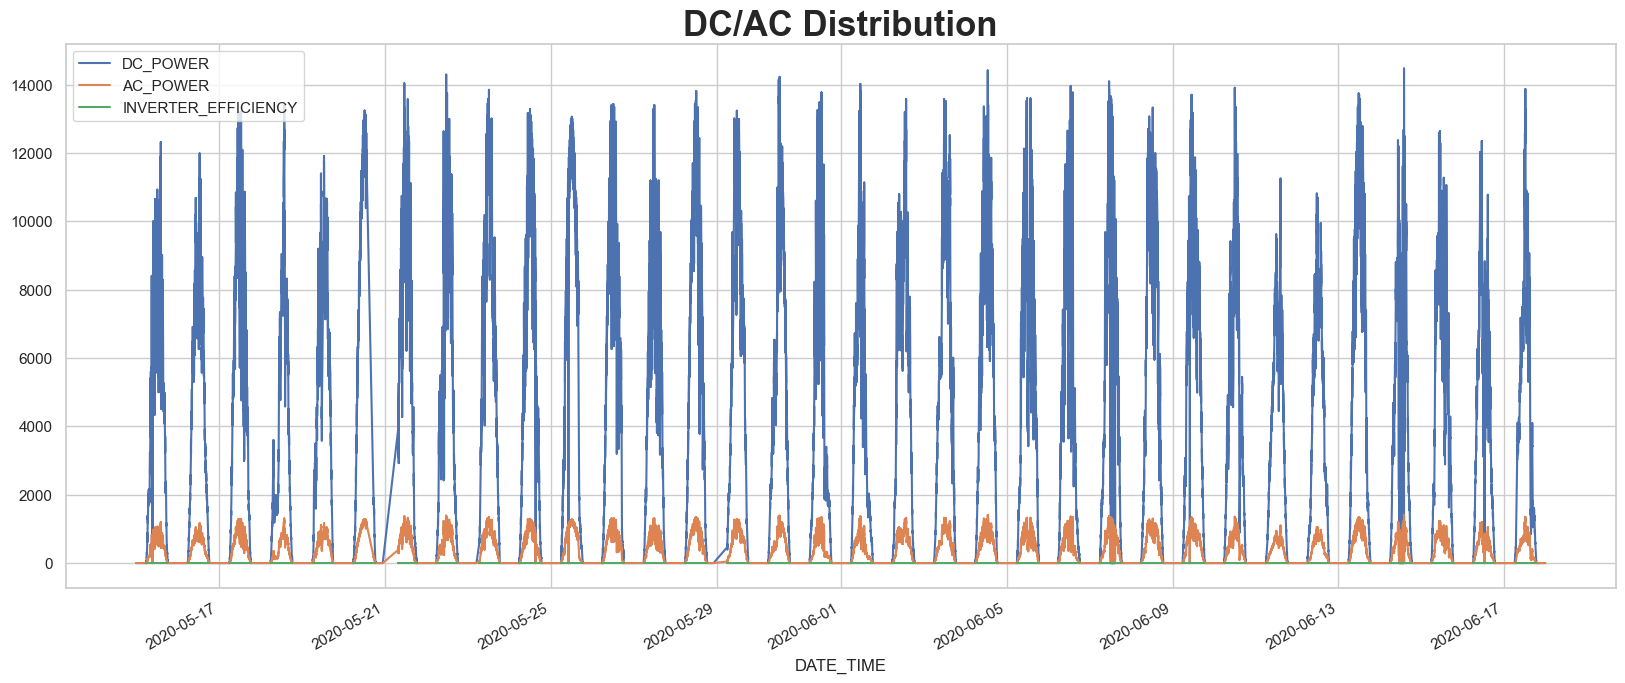

In [14]:
gen_1_ac_dc.plot(figsize=(20,8))
plt.title('DC/AC Distribution', weight='bold', fontsize=25)

** 我们先粗略画一下DC/AC随时间变化的分布图。这张图我们得到的信息有限，但是大概能看到5月19-5月21日之间和6月12和6月13日的DC产量根其他天相比有些低。**

IRRADIATION vs TIME

In [15]:
sen_1 = load_and_clean_sensor(data_path_sen)
sen_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   SOURCE_KEY           3182 non-null   object        
 2   AMBIENT_TEMPERATURE  3182 non-null   float64       
 3   MODULE_TEMPERATURE   3182 non-null   float64       
 4   IRRADIATION          3182 non-null   float64       
 5   HOUR                 3182 non-null   int32         
 6   DATE                 3182 non-null   object        
dtypes: datetime64[ns](1), float64(3), int32(1), object(2)
memory usage: 161.7+ KB


In [16]:
sen_1.head()

,DATE_TIME,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HOUR,DATE
0,2020-05-15 00:00:00,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,2020-05-15
1,2020-05-15 00:15:00,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,0,2020-05-15
2,2020-05-15 00:30:00,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,0,2020-05-15
3,2020-05-15 00:45:00,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,0,2020-05-15
4,2020-05-15 01:00:00,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,1,2020-05-15


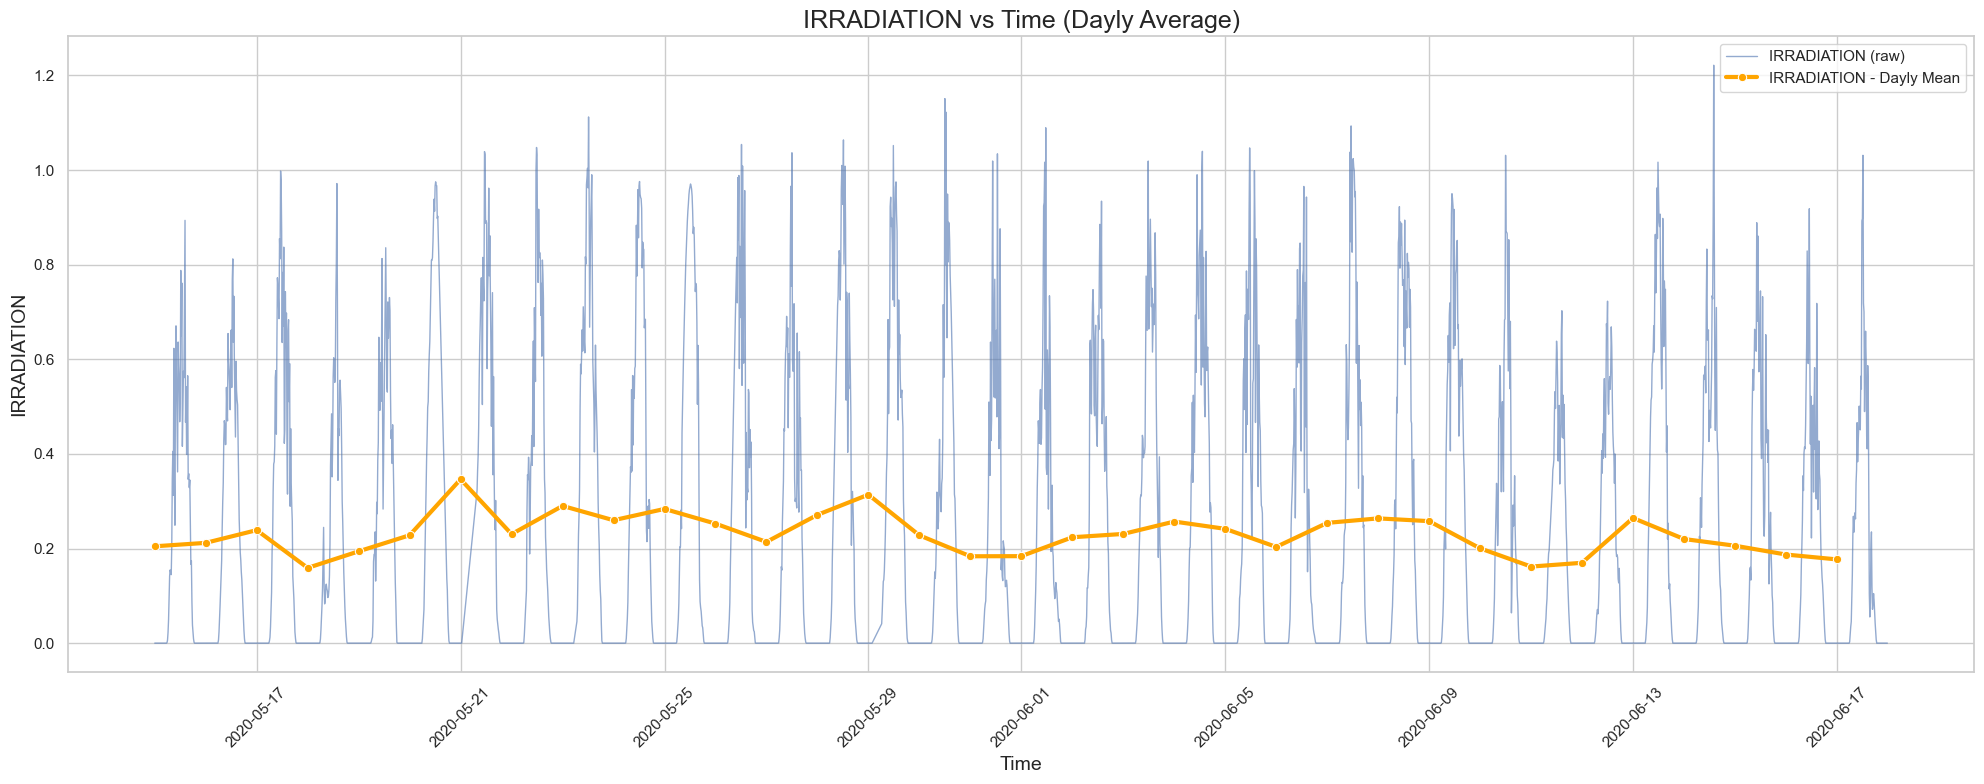

In [17]:
plot_dayly_timeseries(sen_1, column="IRRADIATION")

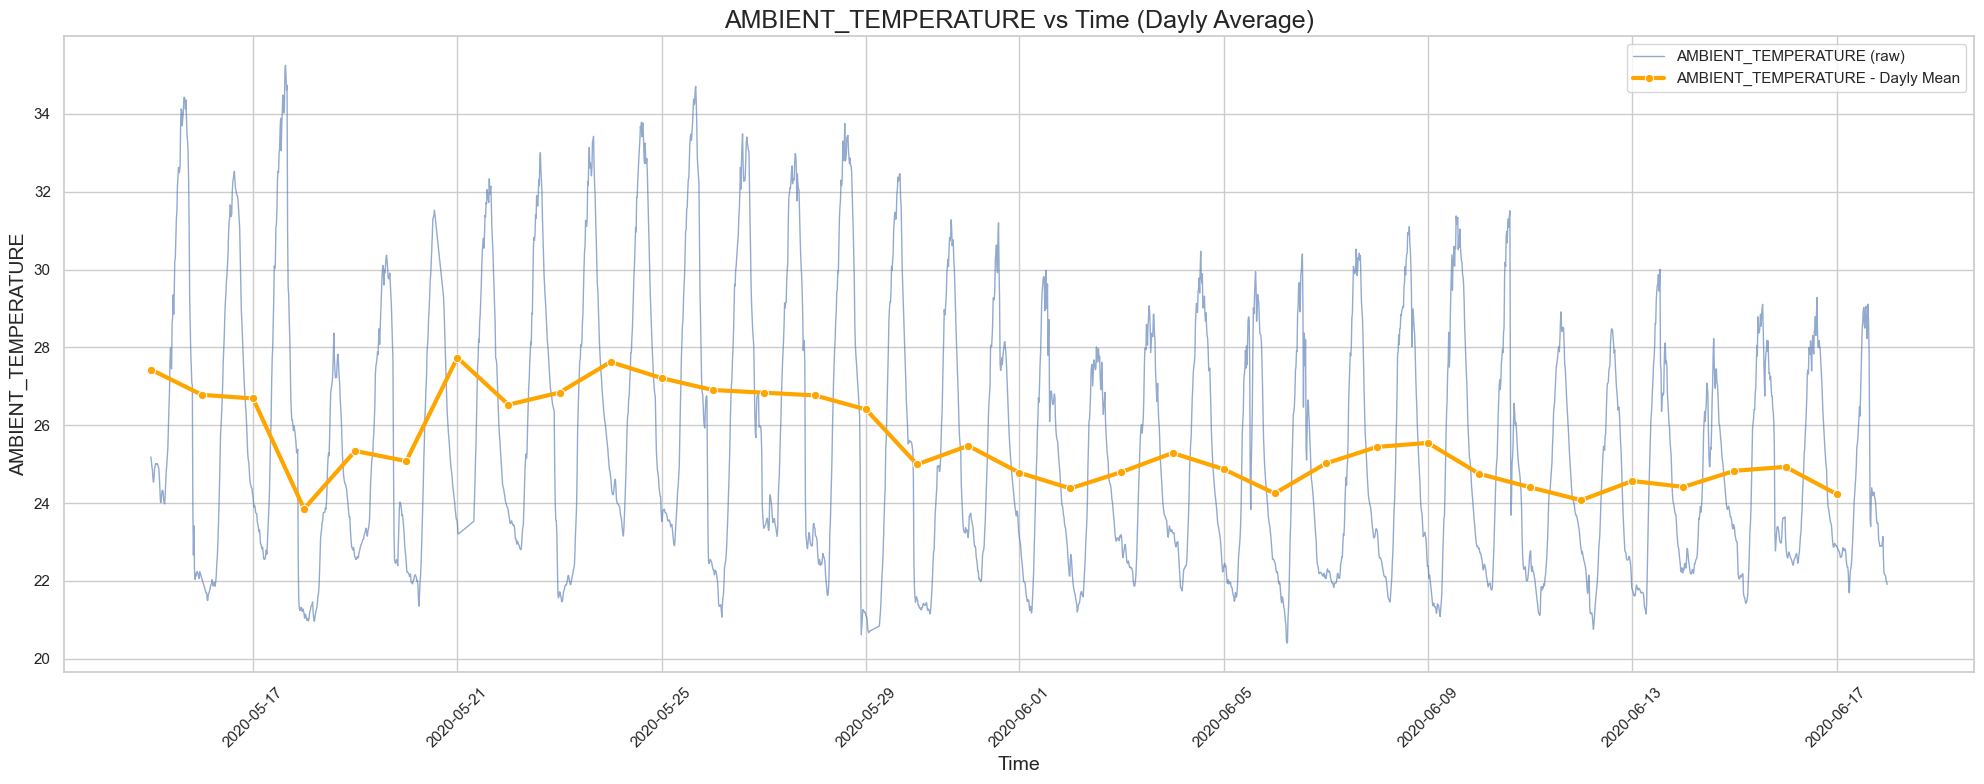

In [20]:
plot_dayly_timeseries(sen_1, column="AMBIENT_TEMPERATURE")

MODULE_TEMPERATURE vs TIME

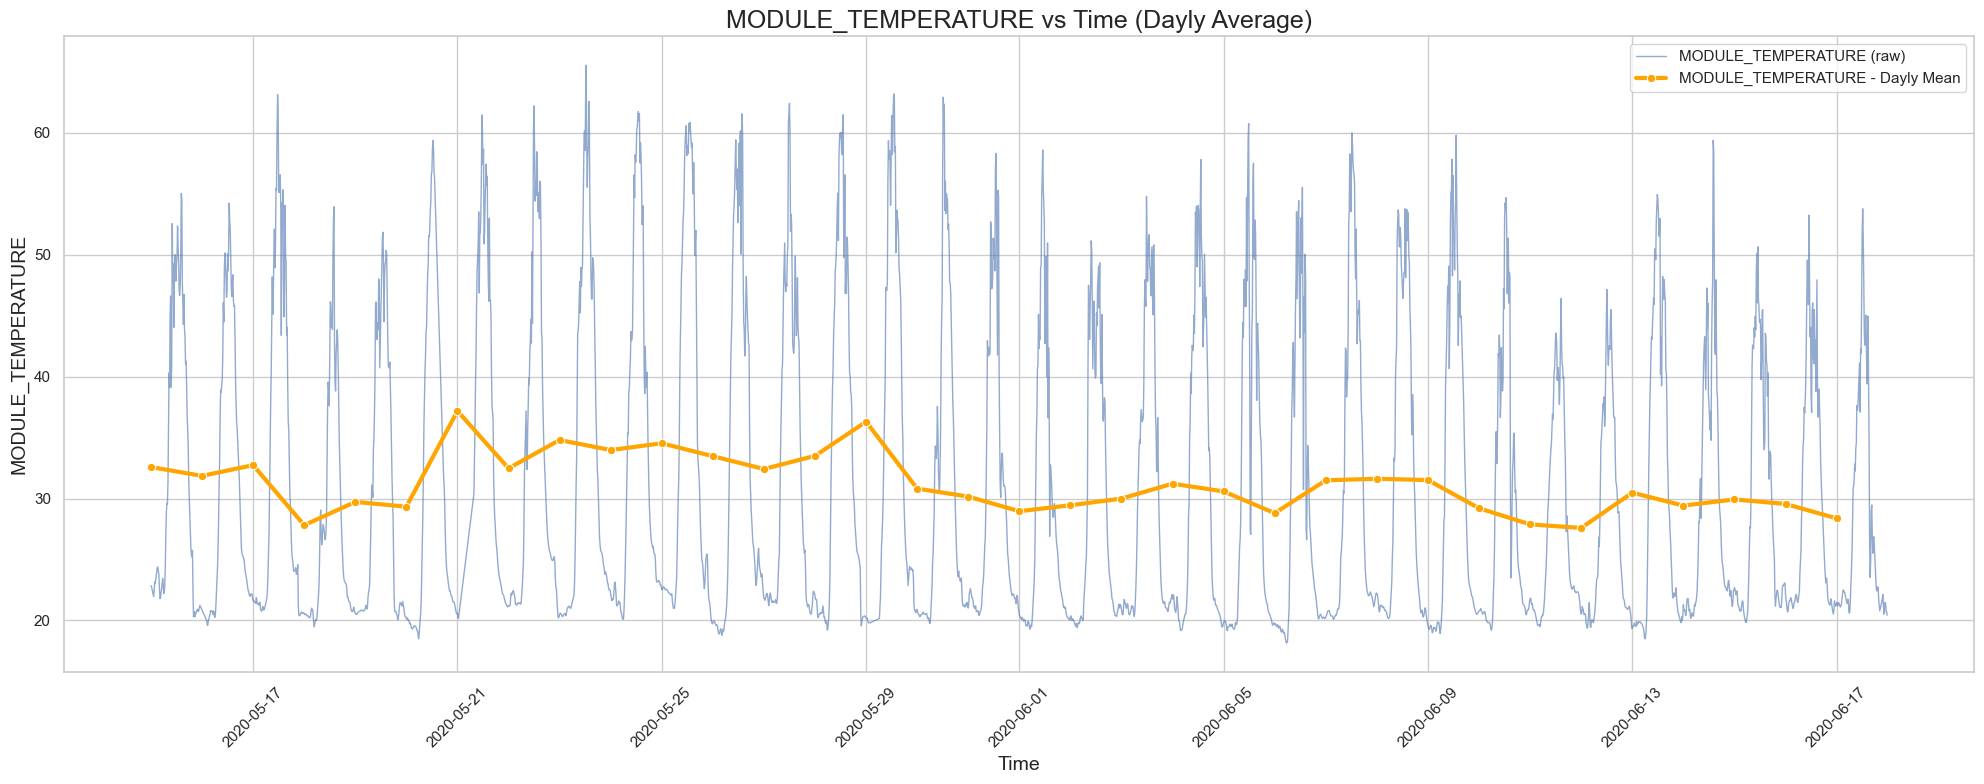

In [19]:
plot_dayly_timeseries(sen_1, column="MODULE_TEMPERATURE")

逆变器别DC/AC箱型图 & 逆变器别效率转换箱型图

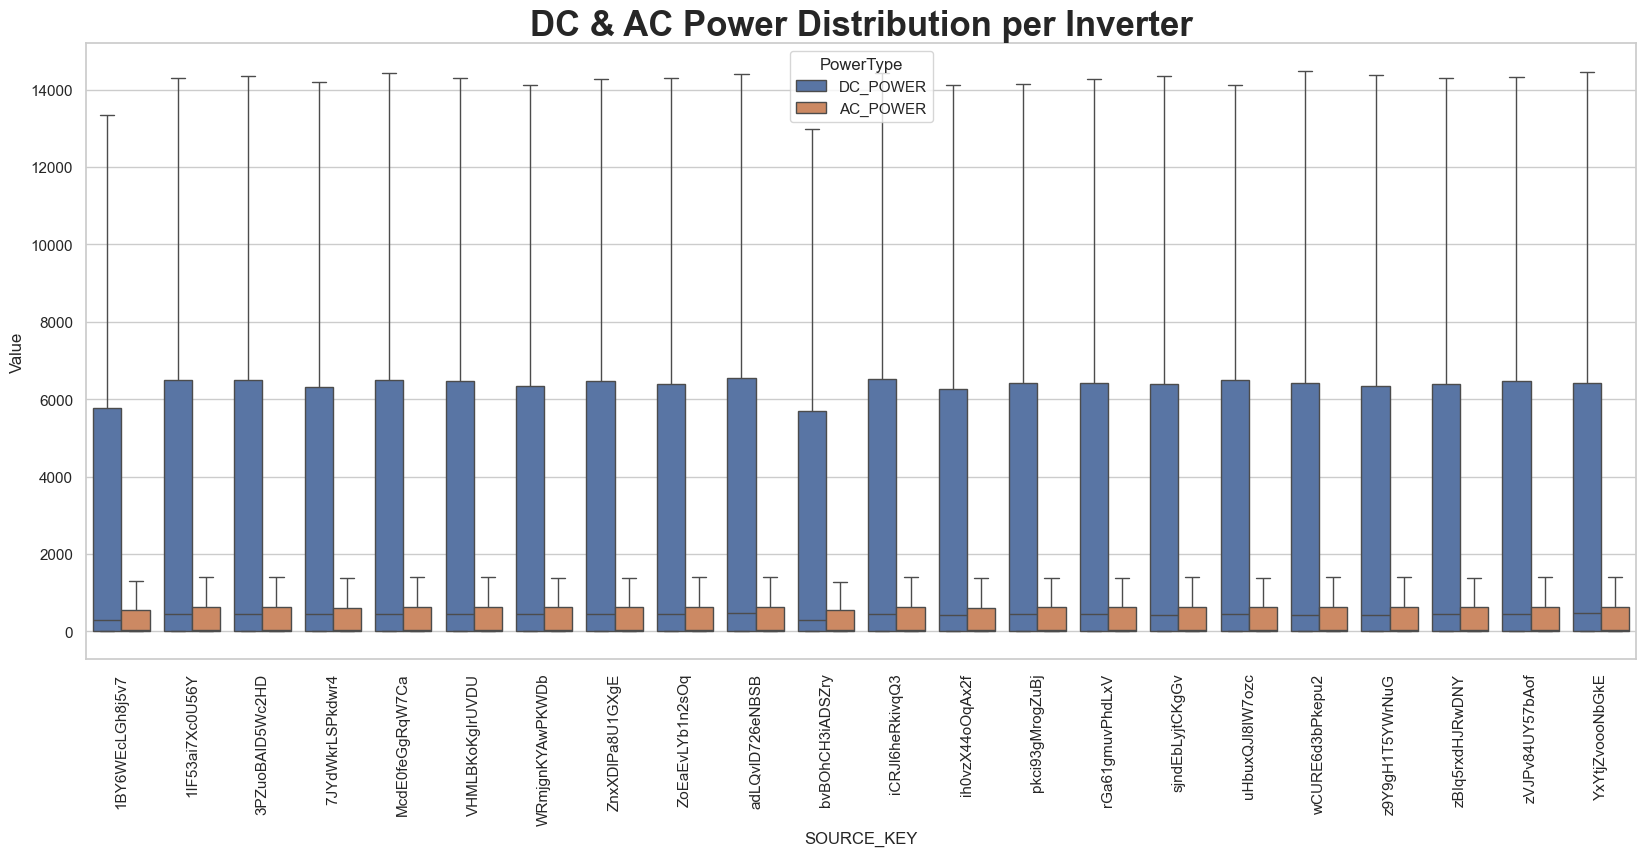

In [ ]:
df_melt = gen_1_ac_dc.melt(
    id_vars="SOURCE_KEY",
    value_vars=["DC_POWER", "AC_POWER"],
    var_name="PowerType",
    value_name="Value"
)
plt.figure(figsize=(20, 8))
sns.boxplot(data=df_melt, x="SOURCE_KEY", y="Value", hue="PowerType")
plt.xticks(rotation=90)
plt.title("DC & AC Power Distribution per Inverter", weight='bold', fontsize=25)
plt.show()

这张图里的1BY6WEcLGh8j5v7和bvBOhCH3iADSZry型号比其他型号看起来DC记录似乎要低，目前还不明确是天气影响，遮挡还是机器本身问题。我们稍后会检查这两个机器。

In [ ]:
gen_1_pivot.head()

SOURCE_KEY,1BY6WEcLGh8j5v7,1IF53ai7Xc0U56Y,3PZuoBAID5Wc2HD,7JYdWkrLSPkdwr4,McdE0feGgRqW7Ca,VHMLBKoKgIrUVDU,WRmjgnKYAwPKWDb,YxYtjZvoooNbGkE,ZnxXDlPa8U1GXgE,ZoEaEvLYb1n2sOq,...,iCRJl6heRkivqQ3,ih0vzX44oOqAx2f,pkci93gMrogZuBj,rGa61gmuvPhdLxV,sjndEbLyjtCKgGv,uHbuxQJl8lW7ozc,wCURE6d3bPkepu2,z9Y9gH1T5YWrNuG,zBIq5rxdHJRwDNY,zVJPv84UY57bAof
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-05-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


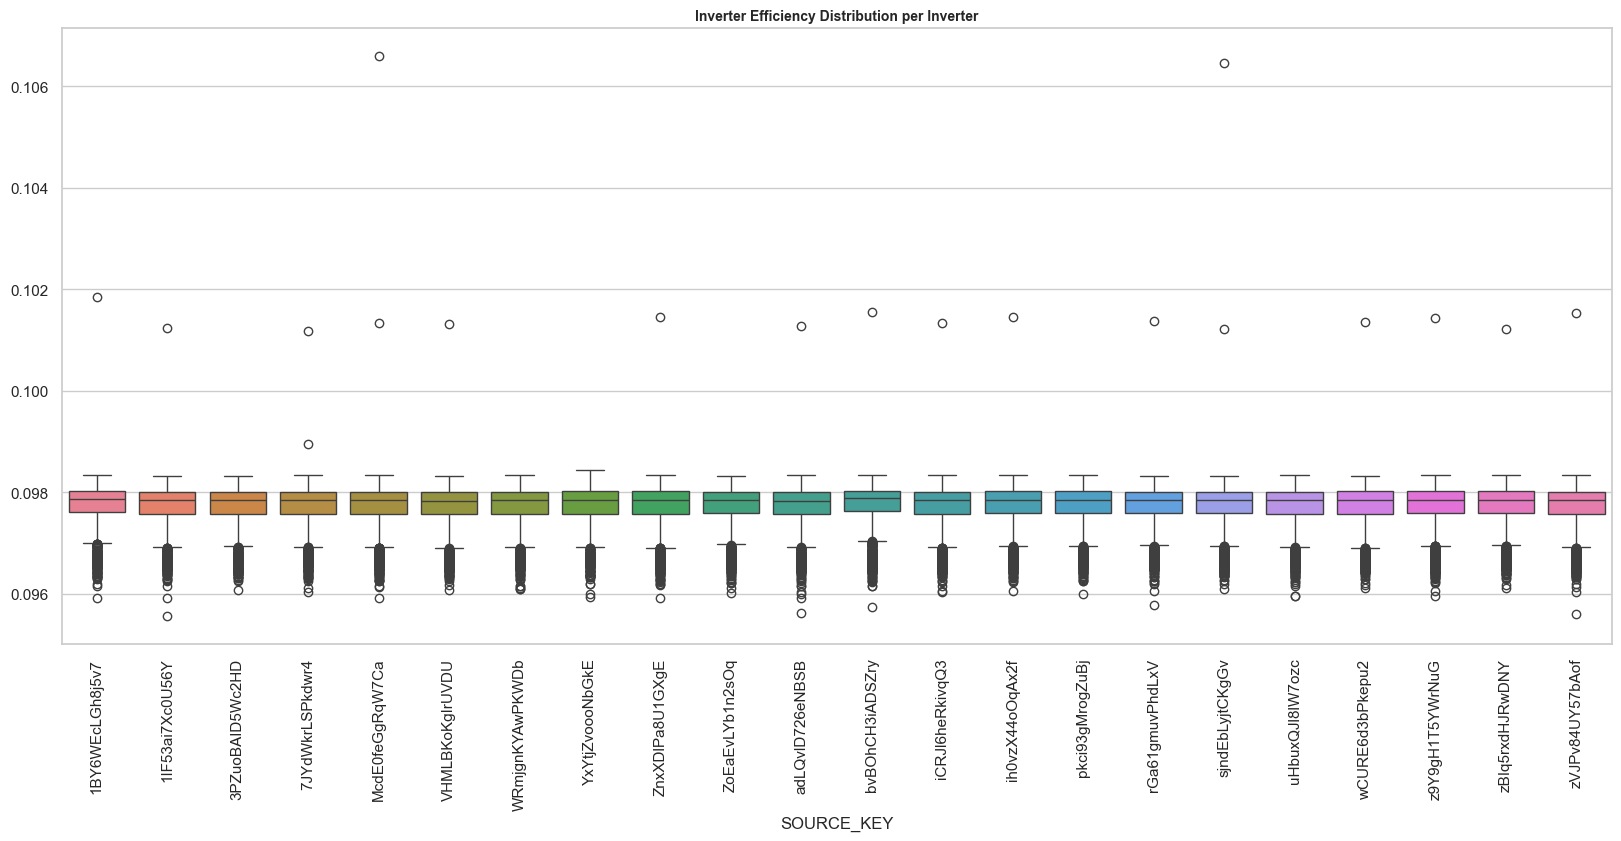

In [ ]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=gen_1_pivot)
plt.xticks(rotation=90)
plt.title("Inverter Efficiency Distribution per Inverter", weight='bold', fontsize=10)
plt.show()

In [ ]:
gen_1_pivot['Hour'] = gen_1_pivot.index.hour
gen_1_pivot['Day'] = gen_1_pivot.index.day
gen_1_pivot.head(3)

SOURCE_KEY,1BY6WEcLGh8j5v7,1IF53ai7Xc0U56Y,3PZuoBAID5Wc2HD,7JYdWkrLSPkdwr4,McdE0feGgRqW7Ca,VHMLBKoKgIrUVDU,WRmjgnKYAwPKWDb,YxYtjZvoooNbGkE,ZnxXDlPa8U1GXgE,ZoEaEvLYb1n2sOq,...,pkci93gMrogZuBj,rGa61gmuvPhdLxV,sjndEbLyjtCKgGv,uHbuxQJl8lW7ozc,wCURE6d3bPkepu2,z9Y9gH1T5YWrNuG,zBIq5rxdHJRwDNY,zVJPv84UY57bAof,Hour,Day
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-05-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15
2020-05-15 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15
2020-05-15 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15


In [ ]:
gen_1_pivot.columns

Index(['1BY6WEcLGh8j5v7', '1IF53ai7Xc0U56Y', '3PZuoBAID5Wc2HD',
       '7JYdWkrLSPkdwr4', 'McdE0feGgRqW7Ca', 'VHMLBKoKgIrUVDU',
       'WRmjgnKYAwPKWDb', 'YxYtjZvoooNbGkE', 'ZnxXDlPa8U1GXgE',
       'ZoEaEvLYb1n2sOq', 'adLQvlD726eNBSB', 'bvBOhCH3iADSZry',
       'iCRJl6heRkivqQ3', 'ih0vzX44oOqAx2f', 'pkci93gMrogZuBj',
       'rGa61gmuvPhdLxV', 'sjndEbLyjtCKgGv', 'uHbuxQJl8lW7ozc',
       'wCURE6d3bPkepu2', 'z9Y9gH1T5YWrNuG', 'zBIq5rxdHJRwDNY',
       'zVJPv84UY57bAof', 'Hour', 'Day'],
      dtype='object', name='SOURCE_KEY')

利用转换率每小时变化箱型图来判断可疑机器

Total inverters: 22


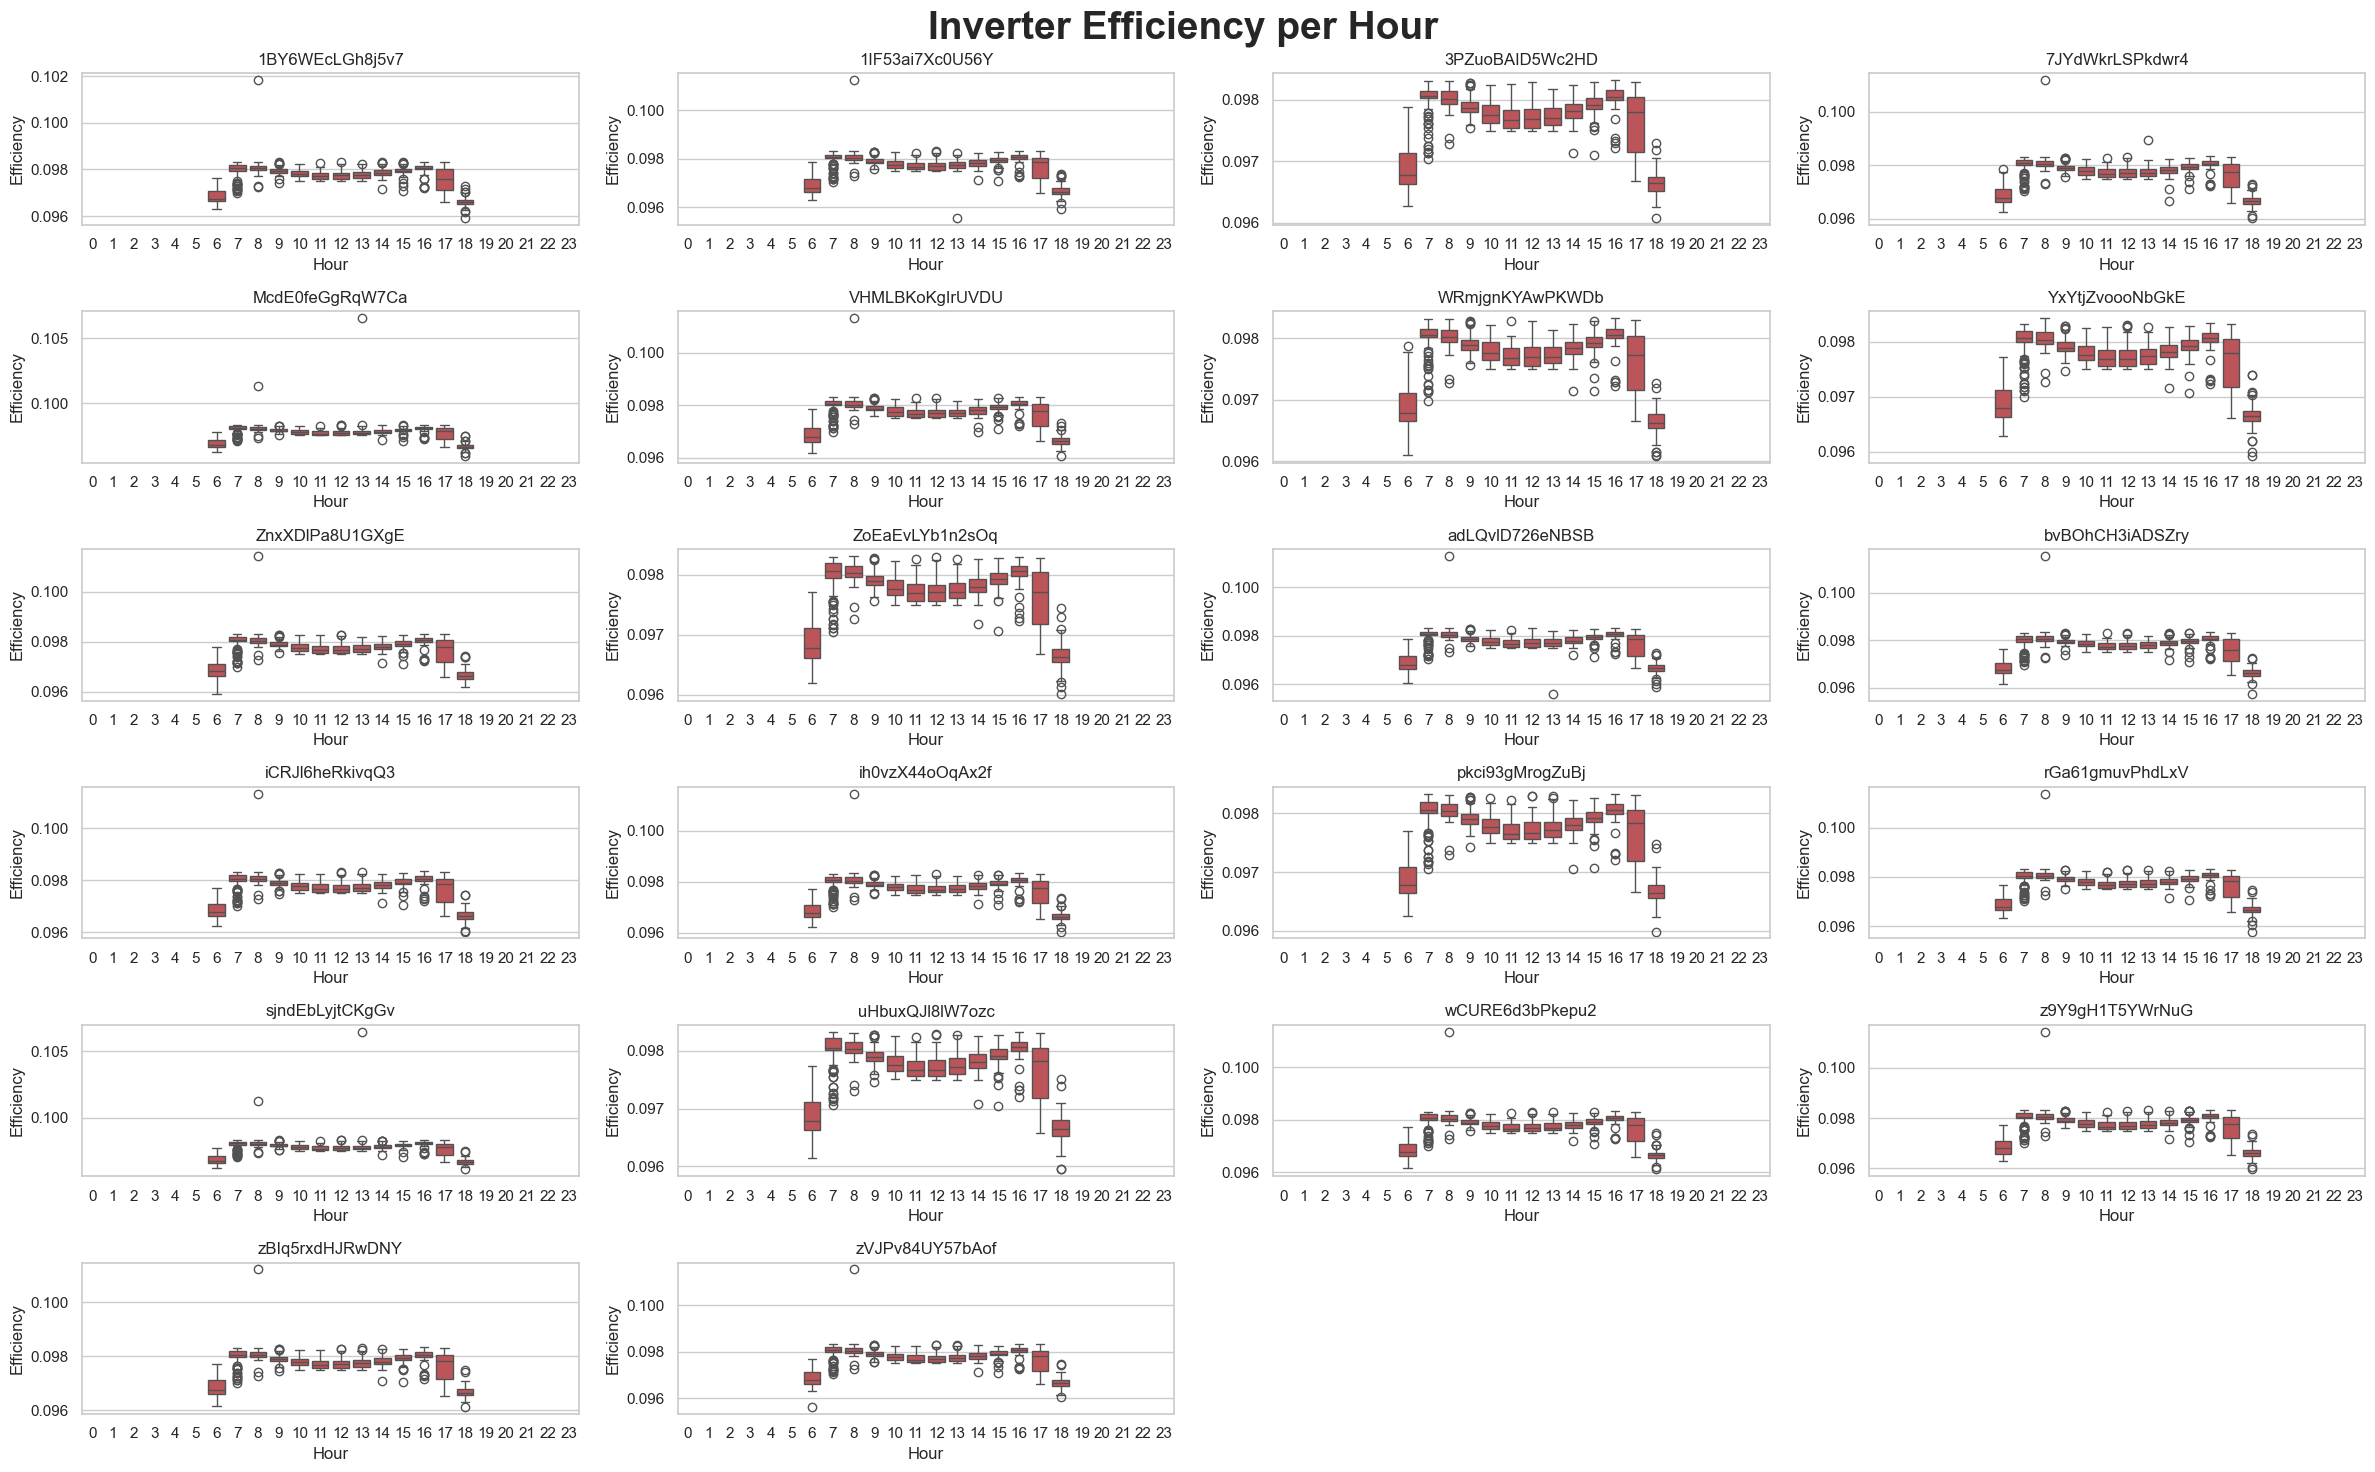

In [ ]:
# 1. 提取逆变器列（排除 Hour, Day）
inverter_cols = [col for col in gen_1_pivot.columns if col not in ['Hour', 'Day']]

# 确认数量是 22
print("Total inverters:", len(inverter_cols))

# 2. 设置画布：6 行 × 4 列 = 24 格，够放 22 张
f, axes = plt.subplots(nrows=6, ncols=4, figsize=(24, 15))
f.suptitle('Inverter Efficiency per Hour', weight='bold', fontsize=28)

axes = axes.flatten()

# 3. 遍历每个逆变器，绘制子图
for i, col in enumerate(inverter_cols):
    sns.boxplot(
        data=gen_1_pivot,
        x=gen_1_pivot.index.hour,         # Hour on x-axis
        y=col,                            # inverter efficiency
        ax=axes[i],
        color='#cc444b'
    )
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel("Hour")
    axes[i].set_ylabel("Efficiency")

# 4. 删除多余的子图（最后两个）
for j in range(len(inverter_cols), len(axes)):
    f.delaxes(axes[j])

plt.tight_layout()
plt.show()
